In [2]:
import numpy as np
import glob
import os
import logging
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
DATA_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\img\1030"

In [3]:
def create_signal_images(target,count,out_path_abp,out_path_ppg):
    px = 256
    def ppg_img(sig,out_path_ppg,count):
        im_arr = np.zeros((px,px),dtype=np.uint8)
        rescaled = (255.0*sig).astype(np.uint8)
        #rescaled = np.array(j).astype(np.uint8)
        im_arr[:,:] = rescaled[:,None]
        im = Image.fromarray(im_arr.T)
        im.save(out_path_ppg.format(count))
        return 
    def abp_img(sig,out_path_abp,count):
        im_arr = np.zeros((px,px),dtype=np.uint8)
        abp_max = 255
        abp_min = 0
        rescaled = (255.0/(abp_max-abp_min)*(sig-abp_min)).astype(np.uint8)
        im_arr[:,:] = rescaled[:,None]
        im = Image.fromarray(im_arr.T)
        im.save(out_path_abp.format(count))
        return
    for i in range(0,len(target)-px,px):
        s = target[i:i+px,:]
        abp_img(s[:,0],out_path_abp,count)
        ppg_img(s[:,1],out_path_ppg,count)
        count+=1
    return count

In [4]:
def create_image_executor(dir1):
    DATA_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
    OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\img\1030"
    os.makedirs(f"{OUTPUT_DIR}\\abp\p00\{dir1}",exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}\\ppg\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path_abp = f"{OUTPUT_DIR}\\abp\p00\{dir1}\\"+"{:07d}.png"
    out_path_ppg = f"{OUTPUT_DIR}\\ppg\p00\{dir1}\\"+"{:07d}.png"
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        nan_locs = np.where(np.isnan(sig))[0]
        count = 0
        for n in range(len(nan_locs)-1):
            target = sig[nan_locs[n]+1:nan_locs[n+1]]
            count = create_signal_images(target,count,out_path_abp,out_path_ppg)

In [58]:
def create_npy_executor(dir1):
    px = 256
    max= 200
    DATA_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
    OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_norm"
    os.makedirs(f"{OUTPUT_DIR}\\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path = f"{OUTPUT_DIR}\\p00\{dir1}\\{dir1}_"+"{:06d}.npy"
    count = 0
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        sig[:,0] = sig[:,0]/max
        nan_locs = np.where(np.isnan(sig))[0]
        for n in range(len(nan_locs)-1):
            target = sig[nan_locs[n]+1:nan_locs[n+1]]
            for i in range(0,len(target)-px,px):
                s = target[i:i+px,:]
                np.save(out_path.format(count),s.astype(np.float16))
                count+=1

In [59]:
import concurrent.futures
import time
from multiprocessing import Pool
dirs = glob.glob("p*",root_dir=DATA_DIR)
# futures =[]
# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
# p = Pool(8) # プロセス数を4に設定
for i in tqdm(range(len(dirs))):
    patients_num = int(dirs[i][1:])
    # print(patients_num)
    # if patients_num < 4680:
    #     continue
    # create_image_executor(dirs[i])
    create_npy_executor(dirs[i])
        # futures.append(executor.submit(create_image_executor,dirs[i]))
    # concurrent.futures.wait(futures,timeout=None,return_when=concurrent.futures.ALL_COMPLETED)
    # executor.shutdown()
print("done")
    

  2%|▏         | 2/121 [01:12<1:11:49, 36.21s/it]


KeyboardInterrupt: 

# filename修正
p000000_000000.png

In [12]:
# OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\img\1030\abp\p00"
OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\sig_npy\1101_norm\p00"
dirs = glob.glob("p*",root_dir=OUTPUT_DIR)
for i in tqdm(range(len(dirs))):
    patients = dirs[i]
    files = glob.glob(patients+"\*",root_dir=OUTPUT_DIR)
    for f in files:
        #p123456/1234567.png
        n = f[-10:-4]
        # newname = f"{patients}_{n}.png"
        newname = f"{n}.npy"
        os.rename(os.path.join(OUTPUT_DIR,f),os.path.join(OUTPUT_DIR,patients,newname)) 
        

100%|██████████| 121/121 [06:22<00:00,  3.16s/it]


7:3に分割　patients単位

100%|██████████| 121/121 [00:27<00:00,  4.42it/s]


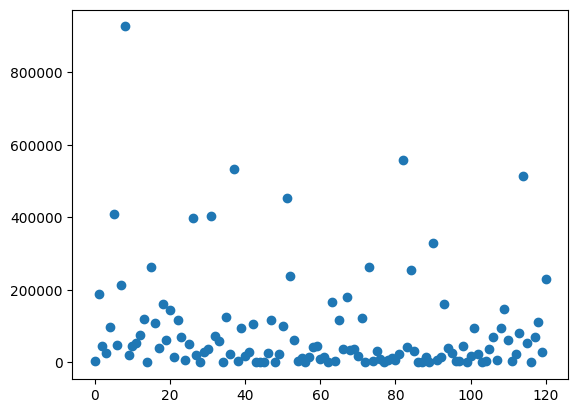

In [69]:
OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat\p00"
dirs = glob.glob("p*.npy",root_dir=OUTPUT_DIR)
nums = []
for i in tqdm(range(len(dirs))):
    npy = np.load(os.path.join(OUTPUT_DIR,dirs[i]))
    nums.append(npy.shape[0])
plt.scatter(np.arange(0,len(nums)),nums)

In [71]:
npy.dtype

dtype('float16')

In [70]:
sum = np.sum(nums)
print("sum",sum)
train_ratio = int(0.7 * sum)
count = 0
p_test = []
p_train = []
i = 0
while train_ratio > count:
    p_train.append(dirs[i])
    count += nums[i]
    i+= 1
    
for j in range(i,len(dirs)):
    p_test.append(dirs[j])

p_train = "\n".join(p_train)
p_test = "\n".join(p_test)

with open("../data/processed/list/train_p00.txt", mode="w") as tr, open("../data/processed/list/test_p00.txt", mode="w") as t:
    tr.writelines(p_train)
    t.writelines(p_test)




sum 10733171


flistを作成(Palette\preprocess\mirflickr25k_preprocess.py)

In [23]:
DIR= "img/1030"
# DIR= "sig_npy/1101_norm"
with open("../data/processed/list/train_p00.txt", mode="r") as tr, open(f"../data/processed/{DIR}/train.flist",mode='w') as f:
    l = tr.readlines()
    for i in tqdm(range(len(l))):
        dir = l[i]
        # print(dir[:-1])
        files=glob.glob(f"{dir[:-1]}/*.png",root_dir=f"../data/processed/{DIR}/abp/p00")
        # files=glob.glob(f"{dir[:-1]}/*.npy",root_dir=f"../data/processed/{DIR}/p00")
        # print(len(files))
        for file in files:
            print(file[:-4],file=f)


100%|██████████| 82/82 [00:04<00:00, 16.42it/s]


In [22]:
# DIR= "sig_npy/1101_norm"
DIR= "img/1030"
with open("../data/processed/list/test_p00.txt", mode="r") as tr, open(f"../data/processed/{DIR}/test.flist",mode='w') as f:
    l = tr.readlines()
    for i in tqdm(range(len(l))):
        dir = l[i]
        # print(dir[:-1])
        # files=glob.glob(f"{dir[:-1]}/*.npy",root_dir=f"../data/processed/{DIR}/p00")
        files=glob.glob(f"{dir[:-1]}/*.png",root_dir=f"../data/processed/{DIR}/abp/p00")
        # print(len(files))
        for file in files:
            print(file[:-4],file=f)

100%|██████████| 39/39 [00:01<00:00, 20.82it/s]


連結

In [67]:
def create_npy_executor_big(dir1):
    px = 256
    max= 200
    DATA_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
    OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat"
    # os.makedirs(f"{OUTPUT_DIR}\\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path = f"{OUTPUT_DIR}\\p00\{dir1}.npy"
    s = []
    count = 0
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        sig[:,0] = sig[:,0]/max
        nan_locs = np.where(np.isnan(sig[:,0]))[0]
        # print(len(nan_locs))
        
        for n in range(len(nan_locs)-1):
            target = sig[nan_locs[n]+1:nan_locs[n+1]]
            for i in range(0,len(target)-px,px):
                s.append(target[i:i+px,:].astype(np.float16))
                # count+=1
        # print(count)
    if len(s):
        s = np.stack(s,dtype=np.float16)
        print(s.shape)
        np.save(out_path,s)
    else:
        print("##### NO SIGNAL:", dir1)
        

In [68]:
import concurrent.futures
import time
from multiprocessing import Pool
dirs = glob.glob("p*",root_dir=DATA_DIR)
# futures =[]
# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
# p = Pool(8) # プロセス数を4に設定
for i in tqdm(range(len(dirs))):
    patients_num = int(dirs[i][1:])
    # print(patients_num)
    # if patients_num < 4680:
    #     continue
    # create_image_executor(dirs[i])
    create_npy_executor_big(dirs[i])
        # futures.append(executor.submit(create_image_executor,dirs[i]))
    # concurrent.futures.wait(futures,timeout=None,return_when=concurrent.futures.ALL_COMPLETED)
    # executor.shutdown()
print("done")

  0%|          | 0/121 [00:00<?, ?it/s]

(5161, 256, 2)
(189844, 256, 2)


  2%|▏         | 3/121 [00:02<01:46,  1.11it/s]

(44673, 256, 2)


  3%|▎         | 4/121 [00:03<01:21,  1.43it/s]

(24947, 256, 2)
(98371, 256, 2)


  4%|▍         | 5/121 [00:04<01:32,  1.26it/s]

(410066, 256, 2)


  5%|▍         | 6/121 [00:09<04:12,  2.19s/it]

(48623, 256, 2)


  6%|▌         | 7/121 [00:09<03:15,  1.72s/it]

(213968, 256, 2)


  7%|▋         | 8/121 [00:13<04:00,  2.13s/it]

(925962, 256, 2)


  8%|▊         | 10/121 [00:24<06:22,  3.45s/it]

(21040, 256, 2)
(44729, 256, 2)


  9%|▉         | 11/121 [00:24<04:40,  2.55s/it]

(53487, 256, 2)


 10%|▉         | 12/121 [00:25<03:30,  1.93s/it]

(75411, 256, 2)


 11%|█         | 13/121 [00:26<03:02,  1.69s/it]

(120212, 256, 2)


 12%|█▏        | 14/121 [00:28<03:00,  1.69s/it]

(1475, 256, 2)
(262049, 256, 2)


 13%|█▎        | 16/121 [00:31<02:47,  1.60s/it]

(107928, 256, 2)


 15%|█▍        | 18/121 [00:32<02:06,  1.23s/it]

(40086, 256, 2)
(160104, 256, 2)


 16%|█▌        | 19/121 [00:34<02:23,  1.40s/it]

(61109, 256, 2)


 17%|█▋        | 20/121 [00:35<01:59,  1.18s/it]

(144386, 256, 2)


 18%|█▊        | 22/121 [00:37<01:53,  1.14s/it]

(15550, 256, 2)
(117952, 256, 2)


 19%|█▉        | 23/121 [00:39<02:02,  1.25s/it]

(69181, 256, 2)


 21%|██        | 25/121 [00:40<01:22,  1.17it/s]

(6776, 256, 2)
(51768, 256, 2)


 21%|██▏       | 26/121 [00:41<01:13,  1.29it/s]

(398453, 256, 2)


 23%|██▎       | 28/121 [00:46<02:13,  1.44s/it]

(21161, 256, 2)
(166, 256, 2)
(28662, 256, 2)


 26%|██▌       | 31/121 [00:46<01:05,  1.37it/s]

(36543, 256, 2)
(404564, 256, 2)


 26%|██▋       | 32/121 [00:51<02:39,  1.79s/it]

(71628, 256, 2)


 27%|██▋       | 33/121 [00:52<02:15,  1.54s/it]

(59462, 256, 2)


 28%|██▊       | 34/121 [00:53<01:52,  1.29s/it]

(1486, 256, 2)
(125739, 256, 2)


 31%|███       | 37/121 [00:54<01:13,  1.15it/s]

(23218, 256, 2)
(534289, 256, 2)


 31%|███▏      | 38/121 [01:01<03:16,  2.37s/it]

(3002, 256, 2)
(94007, 256, 2)


 34%|███▍      | 41/121 [01:02<01:38,  1.24s/it]

(16904, 256, 2)


 35%|███▍      | 42/121 [01:03<01:21,  1.03s/it]

(30216, 256, 2)
(105866, 256, 2)


 36%|███▌      | 43/121 [01:04<01:24,  1.08s/it]

(832, 256, 2)
##### NO SIGNAL: p004113
(1818, 256, 2)


 39%|███▉      | 47/121 [01:04<00:35,  2.07it/s]

(27407, 256, 2)
(117438, 256, 2)


 40%|███▉      | 48/121 [01:06<00:47,  1.55it/s]

##### NO SIGNAL: p004405


 41%|████▏     | 50/121 [01:06<00:38,  1.82it/s]

(22833, 256, 2)
(101414, 256, 2)


 42%|████▏     | 51/121 [01:10<01:23,  1.20s/it]

(454191, 256, 2)


 43%|████▎     | 52/121 [01:34<06:57,  6.05s/it]

(238895, 256, 2)


 44%|████▍     | 53/121 [01:43<07:49,  6.90s/it]

(62442, 256, 2)


 45%|████▌     | 55/121 [01:47<04:54,  4.47s/it]

(3246, 256, 2)


 46%|████▋     | 56/121 [01:47<03:37,  3.35s/it]

(13367, 256, 2)
##### NO SIGNAL: p004904


 48%|████▊     | 58/121 [01:49<02:13,  2.12s/it]

(14932, 256, 2)
(43043, 256, 2)


 50%|████▉     | 60/121 [01:53<02:17,  2.25s/it]

(46508, 256, 2)


 50%|█████     | 61/121 [01:54<01:43,  1.72s/it]

(8385, 256, 2)


 52%|█████▏    | 63/121 [01:56<01:20,  1.39s/it]

(15992, 256, 2)
(2367, 256, 2)
(167036, 256, 2)


 54%|█████▎    | 65/121 [02:09<03:07,  3.36s/it]

(3446, 256, 2)
(115997, 256, 2)


 55%|█████▍    | 66/121 [02:16<03:59,  4.36s/it]

(37500, 256, 2)


 55%|█████▌    | 67/121 [02:19<03:29,  3.88s/it]

(180503, 256, 2)


 57%|█████▋    | 69/121 [02:29<03:33,  4.11s/it]

(34376, 256, 2)
(37872, 256, 2)


 59%|█████▊    | 71/121 [02:31<02:12,  2.64s/it]

(18986, 256, 2)
(121786, 256, 2)


 60%|██████    | 73/121 [02:41<02:43,  3.41s/it]

(471, 256, 2)
(262238, 256, 2)


 62%|██████▏   | 75/121 [03:00<04:21,  5.68s/it]

(3368, 256, 2)


 63%|██████▎   | 76/121 [03:01<03:13,  4.29s/it]

(32494, 256, 2)


 64%|██████▎   | 77/121 [03:01<02:17,  3.13s/it]

(10643, 256, 2)


 65%|██████▌   | 79/121 [03:02<01:09,  1.65s/it]

(759, 256, 2)
(6525, 256, 2)


 66%|██████▌   | 80/121 [03:03<01:09,  1.70s/it]

(13681, 256, 2)


 67%|██████▋   | 81/121 [03:04<00:50,  1.26s/it]

(7429, 256, 2)


 68%|██████▊   | 82/121 [03:05<00:53,  1.38s/it]

(22840, 256, 2)
(558687, 256, 2)


 69%|██████▊   | 83/121 [03:39<06:56, 10.96s/it]

(42643, 256, 2)


 69%|██████▉   | 84/121 [03:41<05:12,  8.45s/it]

(254208, 256, 2)


 71%|███████   | 86/121 [03:57<04:28,  7.68s/it]

(32096, 256, 2)


 73%|███████▎  | 88/121 [03:57<02:17,  4.17s/it]

(272, 256, 2)
(1376, 256, 2)


 74%|███████▍  | 90/121 [03:58<01:14,  2.42s/it]

(13784, 256, 2)
##### NO SIGNAL: p007614
(330096, 256, 2)


 76%|███████▌  | 92/121 [04:15<02:17,  4.74s/it]

(7323, 256, 2)


 77%|███████▋  | 93/121 [04:17<01:49,  3.91s/it]

(14021, 256, 2)
(160473, 256, 2)


 78%|███████▊  | 94/121 [04:27<02:33,  5.69s/it]

(38725, 256, 2)


 79%|███████▉  | 96/121 [04:31<01:33,  3.74s/it]

(26319, 256, 2)


 80%|████████  | 97/121 [04:31<01:04,  2.71s/it]

(5279, 256, 2)
(3379, 256, 2)
(44543, 256, 2)


 83%|████████▎ | 100/121 [04:36<00:45,  2.18s/it]

(1510, 256, 2)


 83%|████████▎ | 101/121 [04:38<00:38,  1.94s/it]

(17860, 256, 2)
(95217, 256, 2)


 85%|████████▌ | 103/121 [04:42<00:35,  1.99s/it]

(22601, 256, 2)


 86%|████████▌ | 104/121 [04:42<00:25,  1.48s/it]

(625, 256, 2)
(2741, 256, 2)


 88%|████████▊ | 106/121 [04:44<00:18,  1.25s/it]

(37141, 256, 2)
(70036, 256, 2)


 89%|████████▉ | 108/121 [04:47<00:16,  1.28s/it]

(6032, 256, 2)
(96202, 256, 2)


 90%|█████████ | 109/121 [04:51<00:23,  1.99s/it]

(146636, 256, 2)


 91%|█████████ | 110/121 [04:58<00:35,  3.20s/it]

(62274, 256, 2)


 93%|█████████▎| 112/121 [05:02<00:22,  2.46s/it]

(4064, 256, 2)


 93%|█████████▎| 113/121 [05:04<00:18,  2.27s/it]

(22799, 256, 2)
(82253, 256, 2)


 94%|█████████▍| 114/121 [05:08<00:20,  2.92s/it]

(513163, 256, 2)


 95%|█████████▌| 115/121 [05:33<00:57,  9.50s/it]

(53430, 256, 2)


 97%|█████████▋| 117/121 [05:37<00:22,  5.53s/it]

(704, 256, 2)
(69430, 256, 2)


 98%|█████████▊| 118/121 [05:40<00:14,  4.93s/it]

(111997, 256, 2)


 99%|█████████▉| 120/121 [05:47<00:03,  3.95s/it]

(30236, 256, 2)
(229712, 256, 2)


100%|██████████| 121/121 [05:58<00:00,  2.96s/it]

done


nan確認

In [12]:
OUTPUT_DIR = r"D:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat\p00"
files = glob.glob(".\*",root_dir=OUTPUT_DIR)
print(len(files))
for file in files:
    a = np.load(OUTPUT_DIR+"\\"+file)
    print(np.sum((np.isnan(a))),file)

121
0 .\p000160.npy
0 .\p000188.npy
0 .\p000333.npy
0 .\p000543.npy
0 .\p000618.npy
0 .\p000652.npy
0 .\p000735.npy
0 .\p000773.npy
0 .\p000801.npy
0 .\p000878.npy
0 .\p001004.npy
0 .\p001038.npy
0 .\p001049.npy
0 .\p001158.npy
0 .\p001190.npy
0 .\p001331.npy
0 .\p001501.npy
0 .\p001606.npy
0 .\p001791.npy
0 .\p001840.npy
0 .\p001855.npy
0 .\p001949.npy
0 .\p001978.npy
0 .\p002045.npy
0 .\p002063.npy
0 .\p002104.npy
0 .\p002343.npy
0 .\p002369.npy
0 .\p002458.npy
0 .\p002513.npy
0 .\p002577.npy
0 .\p002586.npy
0 .\p002636.npy
0 .\p002639.npy
0 .\p002858.npy
0 .\p002906.npy
0 .\p003039.npy
0 .\p003386.npy
0 .\p003617.npy
0 .\p003695.npy
0 .\p003744.npy
0 .\p003866.npy
0 .\p003949.npy
0 .\p004053.npy
0 .\p004113.npy
0 .\p004313.npy
0 .\p004324.npy
0 .\p004331.npy
0 .\p004405.npy
0 .\p004588.npy
0 .\p004679.npy
0 .\p004802.npy
0 .\p004804.npy
0 .\p004833.npy
0 .\p004837.npy
0 .\p004900.npy
0 .\p004904.npy
0 .\p004906.npy
0 .\p004958.npy
0 .\p004966.npy
0 .\p005071.npy
0 .\p005193.npy
0 .\